In [1]:
import numpy as np
import pandas as pd
import missingno as msno
import sklearn.metrics as m
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
# cross validation
from sklearn.model_selection import cross_val_score
# grid search
from sklearn.model_selection import GridSearchCV
# outlier
from sklearn.neighbors import LocalOutlierFactor
# imblearn
from imblearn.over_sampling import SMOTE
# compare models
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, precision_score, recall_score, f1_score
# compose pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
# feature selection
from sklearn.feature_selection import SelectKBest, chi2, RFECV
# models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
# save model
import joblib
import seaborn as sns

In [2]:
# load and read data
df = pd.read_csv('kidney_disease.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 26 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              400 non-null    int64  
 1   age             391 non-null    float64
 2   bp              388 non-null    float64
 3   sg              353 non-null    float64
 4   al              354 non-null    float64
 5   su              351 non-null    float64
 6   rbc             248 non-null    object 
 7   pc              335 non-null    object 
 8   pcc             396 non-null    object 
 9   ba              396 non-null    object 
 10  bgr             356 non-null    float64
 11  bu              381 non-null    float64
 12  sc              383 non-null    float64
 13  sod             313 non-null    float64
 14  pot             312 non-null    float64
 15  hemo            348 non-null    float64
 16  pcv             330 non-null    object 
 17  wc              295 non-null    obj

In [3]:
df.head(2)

,id,age,bp,sg,al,su,rbc,pc,pcc,ba,...,pcv,wc,rc,htn,dm,cad,appet,pe,ane,classification
0,0,48.0,80.0,1.02,1.0,0.0,NaN,normal,notpresent,notpresent,...,44,7800,5.2,yes,yes,no,good,no,no,ckd
1,1,7.0,50.0,1.02,4.0,0.0,NaN,normal,notpresent,notpresent,...,38,6000,NaN,no,no,no,good,no,no,ckd


In [4]:
X = df.drop(['id', 'classification'], axis=1)
y = df['classification']

In [5]:
# display columns with 6 or less unique values
for col in X.columns:
    if X[col].nunique() <= 6:
        print(f'{col} : {X[col].unique()}')

sg : [1.02  1.01  1.005 1.015   nan 1.025]
al : [ 1.  4.  2.  3.  0. nan  5.]
su : [ 0.  3.  4.  1. nan  2.  5.]
rbc : [nan 'normal' 'abnormal']
pc : ['normal' 'abnormal' nan]
pcc : ['notpresent' 'present' nan]
ba : ['notpresent' 'present' nan]
htn : ['yes' 'no' nan]
dm : ['yes' 'no' ' yes' '\tno' '\tyes' nan]
cad : ['no' 'yes' '\tno' nan]
appet : ['good' 'poor' nan]
pe : ['no' 'yes' nan]
ane : ['no' 'yes' nan]


In [6]:
nominal_cols = [col for col in X.columns if (X[col].nunique() <= 6 and X[col].dtype != 'object')]
continuous_cols = [col for col in X.columns if X[col].nunique() > 6]
category_cols = [col for col in X.columns if X[col].dtype == 'object']
print('nominal columns: ', nominal_cols)
print('continuous columns: ', continuous_cols)
print('category columns: ', category_cols)

nominal columns:  ['sg', 'al', 'su']
continuous columns:  ['age', 'bp', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wc', 'rc']
category columns:  ['rbc', 'pc', 'pcc', 'ba', 'pcv', 'wc', 'rc', 'htn', 'dm', 'cad', 'appet', 'pe', 'ane']


In [7]:

# remove all \t and \n from the data
for col in category_cols:
    df[col] = df[col].str.replace('\t', '').replace('\n', '').replace('?', '')

for col in df[category_cols]:
    print(f'{col} : {df[col].unique().tolist()}')


rbc : [nan, 'normal', 'abnormal']
pc : ['normal', 'abnormal', nan]
pcc : ['notpresent', 'present', nan]
ba : ['notpresent', 'present', nan]
pcv : ['44', '38', '31', '32', '35', '39', '36', '33', '29', '28', nan, '16', '24', '37', '30', '34', '40', '45', '27', '48', '', '52', '14', '22', '18', '42', '17', '46', '23', '19', '25', '41', '26', '15', '21', '43', '20', '47', '9', '49', '50', '53', '51', '54']
wc : ['7800', '6000', '7500', '6700', '7300', nan, '6900', '9600', '12100', '4500', '12200', '11000', '3800', '11400', '5300', '9200', '6200', '8300', '8400', '10300', '9800', '9100', '7900', '6400', '8600', '18900', '21600', '4300', '8500', '11300', '7200', '7700', '14600', '6300', '7100', '11800', '9400', '5500', '5800', '13200', '12500', '5600', '7000', '11900', '10400', '10700', '12700', '6800', '6500', '13600', '10200', '9000', '14900', '8200', '15200', '5000', '16300', '12400', '10500', '4200', '4700', '10900', '8100', '9500', '2200', '12800', '11200', '19100', '', '12300', '16700

In [8]:
# make pcv, rc and wc  columns numeric
df['pcv'] = pd.to_numeric(df['pcv'], errors='coerce')
df['wc'] = pd.to_numeric(df['wc'], errors='coerce')
df['rc'] = pd.to_numeric(df['rc'], errors='coerce')

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 26 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              400 non-null    int64  
 1   age             391 non-null    float64
 2   bp              388 non-null    float64
 3   sg              353 non-null    float64
 4   al              354 non-null    float64
 5   su              351 non-null    float64
 6   rbc             248 non-null    object 
 7   pc              335 non-null    object 
 8   pcc             396 non-null    object 
 9   ba              396 non-null    object 
 10  bgr             356 non-null    float64
 11  bu              381 non-null    float64
 12  sc              383 non-null    float64
 13  sod             313 non-null    float64
 14  pot             312 non-null    float64
 15  hemo            348 non-null    float64
 16  pcv             329 non-null    float64
 17  wc              294 non-null    flo

In [10]:
#  update nominal_cols, continuous_cols, category_cols
X = df.drop(['id', 'classification'], axis=1)
y = df['classification']
# \t from y
y = y.str.replace('\t', '').replace('\n', '').replace('?', '')
y = y.replace({'ckd': 1, 'notckd': 0})
nominal_cols = [col for col in X.columns if (X[col].nunique() <= 6 and X[col].dtype != 'object')]
continuous_cols = [col for col in X.columns if X[col].nunique() > 6]
category_cols = [col for col in X.columns if X[col].dtype == 'object']
print('nominal columns: ', nominal_cols)
print('continuous columns: ', continuous_cols)
print('category columns: ', category_cols)

nominal columns:  ['sg', 'al', 'su']
continuous columns:  ['age', 'bp', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wc', 'rc']
category columns:  ['rbc', 'pc', 'pcc', 'ba', 'htn', 'dm', 'cad', 'appet', 'pe', 'ane']


In [11]:
prepNominal = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('scaler', StandardScaler())
])
prepContinuous = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
prepCategory = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(drop='first', sparse_output=False))
])

# combine pipelines
preprocessor = ColumnTransformer([
    ('nominal', prepNominal, nominal_cols),
    ('continuous', prepContinuous, continuous_cols),
    ('category', prepCategory, category_cols)
])

# split data
X_prep = preprocessor.fit_transform(X)
X_prep

array([[ 0.4214856 ,  0.07624929, -0.38026942, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.4214856 ,  2.36372784, -0.38026942, ...,  0.        ,
         0.        ,  0.        ],
       [-1.4210744 ,  0.83874214,  2.50785277, ...,  1.        ,
         0.        ,  1.        ],
       ...,
       [ 0.4214856 , -0.68624357, -0.38026942, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.3427656 , -0.68624357, -0.38026942, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.3427656 , -0.68624357, -0.38026942, ...,  0.        ,
         0.        ,  0.        ]])

In [12]:
# balance data
smote = SMOTE()
X_prep, y = smote.fit_resample(X_prep, y)
y.value_counts()

1    250
0    250
Name: classification, dtype: int64

In [13]:
# select best features using RFECV
selector = RFECV(estimator=LogisticRegression(max_iter=1000), step=1, cv=5, scoring='accuracy')
X_prep = selector.fit_transform(X_prep, y)
X_prep.shape
# columns selected
selected_cols = [col for col, selected in zip(X.columns, selector.support_) if selected]
print(selected_cols)

['age', 'bp', 'sg', 'rbc', 'pcc', 'ba', 'bu', 'sc', 'pot', 'htn', 'dm', 'cad', 'pe', 'ane']


In [14]:
X_prep = pd.DataFrame(X_prep, columns=selected_cols)
X_prep.head()

,age,bp,sg,rbc,pcc,ba,bu,sc,pot,htn,dm,cad,pe,ane
0,0.421486,0.076249,-0.380269,-0.320122,-0.319668,0.040104,1.053226,0.603224,0.550044,1.0,0.0,1.0,0.0,0.0
1,0.421486,2.363728,-0.380269,-0.320122,-0.390819,0.040104,-0.457965,-0.132789,0.074073,0.0,1.0,0.0,0.0,0.0
2,-1.421074,0.838742,2.507853,3.697618,-0.212942,0.040104,-1.084556,-0.991470,0.074073,0.0,0.0,1.0,1.0,0.0
3,-2.342354,2.363728,-0.380269,-0.373337,0.142813,-2.896333,-0.494823,-0.868801,-0.996862,1.0,1.0,0.0,1.0,1.0
4,-1.421074,0.838742,-0.380269,-0.519679,-0.284093,0.040104,-0.347390,-0.500795,-0.163913,0.0,1.0,0.0,0.0,0.0


In [15]:
# final X
#  update nominal_cols, continuous_cols, category_cols
X = df[selected_cols]
nominal_cols = [col for col in X.columns if (X[col].nunique() <= 6 and X[col].dtype != 'object')]
continuous_cols = [col for col in X.columns if X[col].nunique() > 6]
category_cols = [col for col in X.columns if X[col].dtype == 'object']\

y = df['classification']
# \t from y
y = y.str.replace('\t', '').replace('\n', '').replace('?', '')
y = y.replace({'ckd': 1, 'notckd': 0})

print(X.shape, y.shape)

# combine pipelines
preprocessor = ColumnTransformer([
    ('nominal', prepNominal, nominal_cols),
    ('continuous', prepContinuous, continuous_cols),
    ('category', prepCategory, category_cols)
])

print('nominal columns: ', nominal_cols)
print('continuous columns: ', continuous_cols)
print('category columns: ', category_cols)

(400, 14) (400,)
nominal columns:  ['sg']
continuous columns:  ['age', 'bp', 'bu', 'sc', 'pot']
category columns:  ['rbc', 'pcc', 'ba', 'htn', 'dm', 'cad', 'pe', 'ane']


In [16]:
# model 1 full pipe line    
model1 = Pipeline([
    ('preprocessor', preprocessor),
    ('selector', selector),
    ('model', LogisticRegression(max_iter=1000, solver='sag'))
])

# model 2 full pipe line
model2 = Pipeline([
    ('preprocessor', preprocessor),
    ('selector', selector),
    ('model', DecisionTreeClassifier())
])

# model 3 full pipe line
model3 = Pipeline([
    ('preprocessor', preprocessor),
    ('selector', selector),
    ('model', RandomForestClassifier())
])

# model 4 full pipe line
model4 = Pipeline([
    ('preprocessor', preprocessor),
    ('selector', selector),
    ('model', AdaBoostClassifier())
])

# model 5 full pipe line
model5 = Pipeline([
    ('preprocessor', preprocessor),
    ('selector', selector),
    ('model', GradientBoostingClassifier())
])

# model 6 full pipe line
model6 = Pipeline([
    ('preprocessor', preprocessor),
    ('selector', selector),
    ('model', SVC())
])

# model 7 full pipe line
model7 = Pipeline([
    ('preprocessor', preprocessor),
    ('selector', selector),
    ('model', KNeighborsClassifier())
])

# model 8 full pipe line
model8 = Pipeline([
    ('preprocessor', preprocessor),
    ('selector', selector),
    ('model', GaussianNB())
])

# model 9 full pipe line
model9 = Pipeline([
    ('preprocessor', preprocessor),
    ('selector', selector),
    ('model', VotingClassifier(estimators=[('lr', LogisticRegression(max_iter=1000, solver='sag')),
                                        ('dt', DecisionTreeClassifier()),
                                        ('rf', RandomForestClassifier()),
                                        ('ada', AdaBoostClassifier()),
                                        ('gb', GradientBoostingClassifier()),
                                        ('svc', SVC()),
                                        ('knn', KNeighborsClassifier()),
                                        ('gnb', GaussianNB())], voting='hard'))
                                        ])


In [17]:
# fit all models
models = [model1, model2, model3, model4, model5, model6, model7, model8, model9]
for model in models:
    model.fit(X, y)

print(X.shape, y.shape)
X.head(2)


(400, 14) (400,)


,age,bp,sg,rbc,pcc,ba,bu,sc,pot,htn,dm,cad,pe,ane
0,48.0,80.0,1.02,NaN,notpresent,notpresent,36.0,1.2,NaN,yes,yes,no,no,no
1,7.0,50.0,1.02,NaN,notpresent,notpresent,18.0,0.8,NaN,no,no,no,no,no


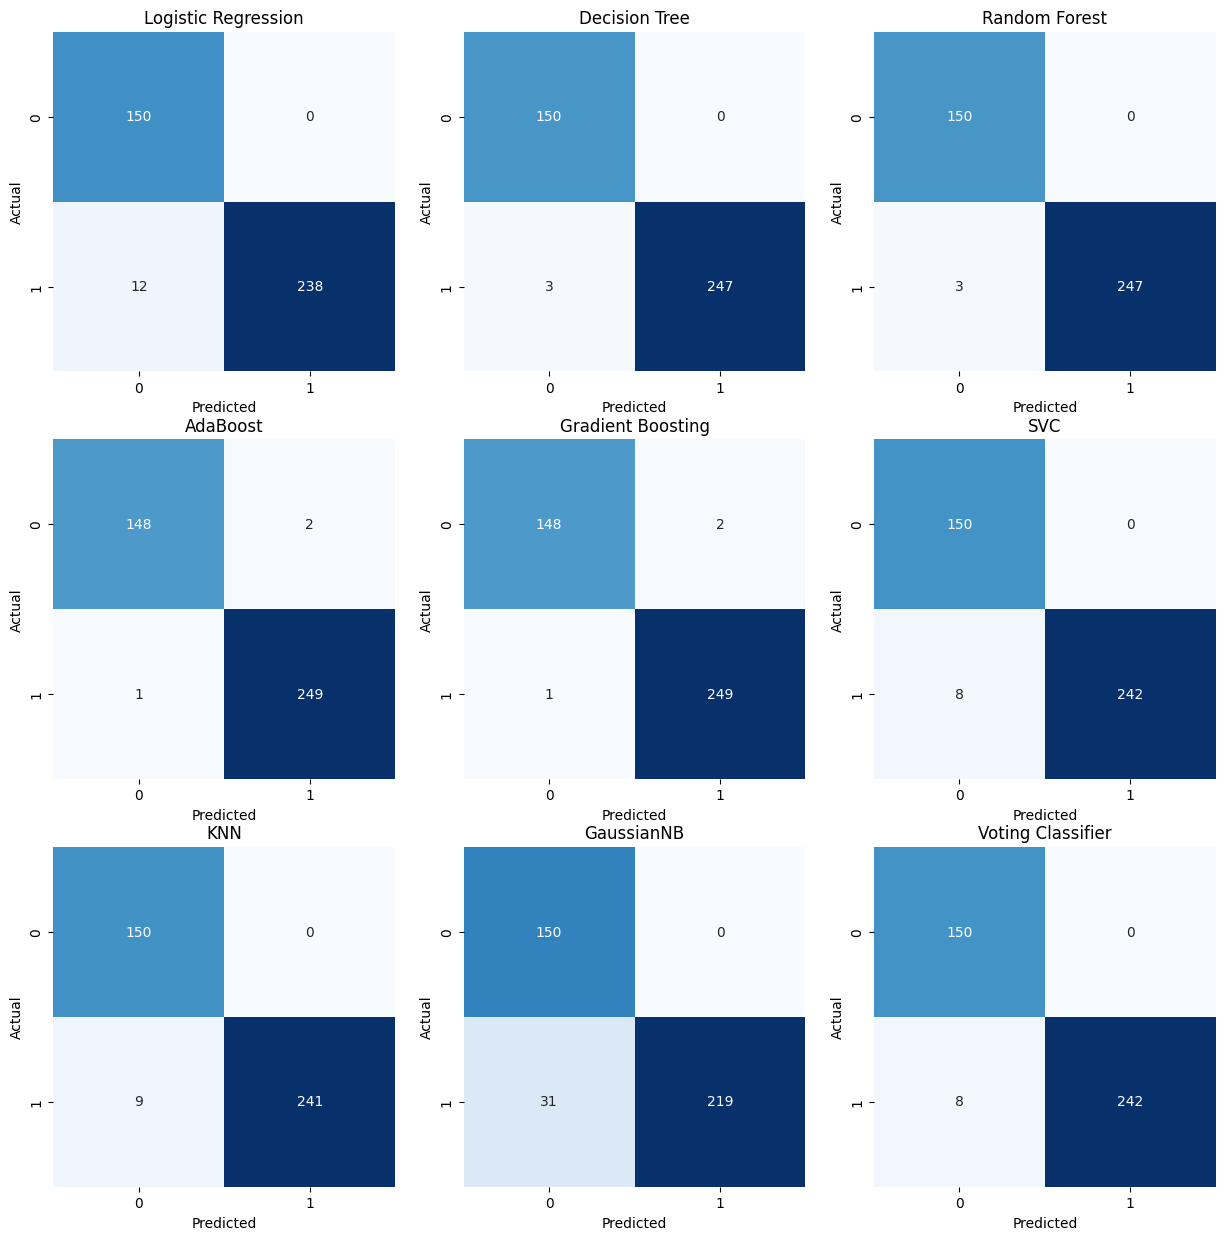

In [18]:
# show 3x3 grid of confusion matrix
fig, axes = plt.subplots(3, 3, figsize=(15, 15), )
model_names = ['Logistic Regression', 'Decision Tree', 'Random Forest', 'AdaBoost', 'Gradient Boosting', 'SVC', 'KNN', 'GaussianNB', 'Voting Classifier']
for ax, model in zip(axes.flatten(), models):
    cf = confusion_matrix(y, model.predict(X))
    sns.heatmap(cf, annot=True, ax=ax, fmt='g', cmap='Blues')
    # remove color bar
    ax.collections[0].colorbar.remove()
    ax.set(title=model_names[models.index(model)], xlabel='Predicted', ylabel='Actual')



In [19]:
# show classification report
for model in models:
    print(model_names[models.index(model)])
    print(classification_report(y, model.predict(X)))
    print()

Logistic Regression
              precision    recall  f1-score   support

           0       0.93      1.00      0.96       150
           1       1.00      0.95      0.98       250

    accuracy                           0.97       400
   macro avg       0.96      0.98      0.97       400
weighted avg       0.97      0.97      0.97       400


Decision Tree
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       150
           1       1.00      0.99      0.99       250

    accuracy                           0.99       400
   macro avg       0.99      0.99      0.99       400
weighted avg       0.99      0.99      0.99       400


Random Forest
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       150
           1       1.00      0.99      0.99       250

    accuracy                           0.99       400
   macro avg       0.99      0.99      0.99       400
weighted avg       0.99 

In [20]:
# best model
best_model = model5
# display best model metrics
print('Best Model', model_names[models.index(best_model)])
print(classification_report(y, best_model.predict(X)))
print()


Best Model Gradient Boosting
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       150
           1       0.99      1.00      0.99       250

    accuracy                           0.99       400
   macro avg       0.99      0.99      0.99       400
weighted avg       0.99      0.99      0.99       400




In [21]:
report = []
for model in models:
    acc = accuracy_score(y, model.predict(X))
    f1 = f1_score(y, model.predict(X))
    recall = recall_score(y, model.predict(X))
    precision = precision_score(y, model.predict(X))
    auc = roc_auc_score(y, model.predict(X))
    report.append({
        'Model': model_names[models.index(model)],
        'Accuracy': acc,
        'F1 Score': f1,
        'Recall': recall,
        'Precision': precision,
        'AUC': auc
    })
report = pd.DataFrame(report, columns=['Model', 'Accuracy', 'F1 Score', 'Recall', 'Precision', 'AUC'])
report.sort_values(by='Accuracy', ascending=False, inplace=True)
report.reset_index(drop=True, inplace=True)
report

,Model,Accuracy,F1 Score,Recall,Precision,AUC
0,Decision Tree,0.9925,0.993964,0.988,1.000000,0.994000
1,Random Forest,0.9925,0.993964,0.988,1.000000,0.994000
2,AdaBoost,0.9925,0.994012,0.996,0.992032,0.991333
3,Gradient Boosting,0.9925,0.994012,0.996,0.992032,0.991333
4,SVC,0.9800,0.983740,0.968,1.000000,0.984000
5,Voting Classifier,0.9800,0.983740,0.968,1.000000,0.984000
6,KNN,0.9775,0.981670,0.964,1.000000,0.982000
7,Logistic Regression,0.9700,0.975410,0.952,1.000000,0.976000
8,GaussianNB,0.9225,0.933902,0.876,1.000000,0.938000


In [22]:
# visualize report
from plotly.subplots import make_subplots
from plotly import graph_objects as go
fig = make_subplots(rows=3, cols=2, subplot_titles=('Accuracy', 'AUC', 'Recall', 'Precision', 'f1 Score'),)
fig.add_trace(
    go.Bar(x=report['Model'], y=report['Accuracy'], marker=dict(color=report['Accuracy'], coloraxis='coloraxis')),
    row=1, col=1
)
fig.add_trace(
    go.Bar(x=report['Model'], y=report['AUC'], marker=dict(color=report['AUC'], coloraxis='coloraxis')),
    row=1, col=2
)
fig.add_trace(
    go.Bar(x=report['Model'], y=report['Recall'], marker=dict(color=report['Recall'], coloraxis='coloraxis')),
    row=2, col=1
)
fig.add_trace(
    go.Bar(x=report['Model'], y=report['Precision'], marker=dict(color=report['Precision'], coloraxis='coloraxis')),
    row=2, col=2
)
fig.add_trace(
    go.Bar(x=report['Model'], y=report['F1 Score'], marker=dict(color=report['F1 Score'], coloraxis='coloraxis')),
    row=3, col=1
)
fig.update_layout(coloraxis=dict(colorscale='Bluered_r'), showlegend=False,height=1000, width=1000, title_text='Model Comparison')
fig.show()


In [23]:
# save all models
for model in models:
    joblib.dump(model, f'{model_names[models.index(model)]}.pkl')


In [28]:
model_names

['Logistic Regression',
 'Decision Tree',
 'Random Forest',
 'AdaBoost',
 'Gradient Boosting',
 'SVC',
 'KNN',
 'GaussianNB',
 'Voting Classifier']

In [24]:
# load models
def load_models():
    models = []
    for model in model_names:
        models.append(joblib.load(f'{model}.pkl'))
    return models


In [25]:
# predict function
def predict(data):
    models = load_models()
    results = []
    for model in models:
        results.append(model.predict(data)[0])  
    # return most frequent prediction
    most_frequent = np.bincount(results).argmax()
    return most_frequent

In [26]:
X.iloc[0:1, :]

,age,bp,sg,rbc,pcc,ba,bu,sc,pot,htn,dm,cad,pe,ane
0,48.0,80.0,1.02,NaN,notpresent,notpresent,36.0,1.2,NaN,yes,yes,no,no,no


In [27]:
# test 100 records
model.predict(X)


array([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,